# semopy quickstart

This notebook should be treated as a secondanary (at best) source of information on the **semopy** usage. For a more throughout description of the package, visit the [Tutorial section](https://semopy.com/tutorial.html) of the website.

## Fitting SEM models to data

**semopy**'s pilestones are model classes, namely:
1. `Model` - a regular SEM model you'd expect to meet in other SEM/CFA software.
2. `ModelMeans` - same as `Model`, but it can model variables means and treats exogenous observed variables as fixed effects (i.e. they reside together with means in the models meanstructure).
3. `ModelEffects` - an extension of `ModelMeans` that can take population structure into an account by introducing random effects into the model. It can be thought as a generalization of LMMs to SEM.
4. `ModelGeneralizedEffects` - an even further extension of `ModelEffects`. It breds SEM with Gaussian processes and can tackle a variety of phenomena, such as spatial data and time series (or even both at the same time). It has "Generalized Effects" in name because that's at its essense is still a random effects model, but the difference is that a covariance-across observations matrix $K$ is parameterized and a number of random effects is arbitrary. **At the moment it is not covered by this Notebook, I'll update it in future as soon as a main article is ready.**

One should feed the description of a model in text form to constructors of those classes, and then invoke the `fit` method. The text description uses similar syntax to that which is popular to describe linear models in R. If you've used **lavaan**, you'd certainly find it very familiar. See the [Syntax and constraints](https://semopy.com/syntax.html) subsection of the tutorial for more details.

For example, let's assume that SEM model we want to work with is just a multivariate regression:

$$ y = x_1 + x_2 + x_3 + \epsilon$$

In **semopy** syntax it is:

In [2]:
from semopy.examples import multivariate_regression
desc = multivariate_regression.get_model()
print(desc)

y1, y2, y3 ~ x1 + x2 + x3


Now, let's instantiate a `Model` object:

In [3]:
from semopy import Model
m = Model(desc)

Then we'd like to fit the `Model` to data. We will use data that is provided by **semopy** package together with `multivariate_regression` toy model:

In [4]:
data = multivariate_regression.get_data()
data.head()

,y1,y2,y3,x1,x2,x3
0,-1.989468,-0.015637,-0.162064,-0.086448,-0.728435,-0.158917
1,-0.777919,4.919949,1.222909,-0.722815,-0.552797,-2.290903
2,-1.951388,1.024939,2.402742,0.127013,0.796024,-0.040658
3,-2.084306,1.430075,-0.308923,0.317103,-0.015630,0.915825
4,1.729722,-3.632137,-2.926315,0.129123,-1.922594,1.652257


Now, we estimate parameters and print optimizer result (to see if everything is OK):

In [5]:
r = m.fit(data)
print(r)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.068
Number of iterations: 17
Params: -1.390 -1.138 -0.318 -0.746 1.074 -1.131 0.703 1.235 -0.920 0.489 0.638 1.136


All models are equipped with the `inspect` method. It is the most useful method you'd find in **semopy**, actually! It outputs parameters estimates in a fancy pandas DataFrame:

In [6]:
ins = m.inspect()
ins

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,y1,~,x1,-1.389754,0.073417,-18.929470,0.000000e+00
1,y1,~,x2,-1.138405,0.087966,-12.941462,0.000000e+00
2,y1,~,x3,-0.317893,0.072576,-4.380132,1.186073e-05
3,y2,~,x1,-0.745837,0.097974,-7.612623,2.686740e-14
4,y2,~,x2,1.074436,0.117388,9.152855,0.000000e+00
5,y2,~,x3,-1.130890,0.096851,-11.676597,0.000000e+00
6,y3,~,x1,0.702778,0.064270,10.934755,0.000000e+00
7,y3,~,x2,1.235044,0.077006,16.038334,0.000000e+00
8,y3,~,x3,-0.920469,0.063534,-14.487925,0.000000e+00
9,y3,~~,y3,0.488735,0.069118,7.071068,1.537437e-12


Okay, that was quiet a simple model. Let's augment it a bit by introducing an extra relationship between $x_3$ and $x_2$:

In [7]:
desc += '\nx1 ~ x3'
print(desc)

y1, y2, y3 ~ x1 + x2 + x3
x1 ~ x3


I'll be honest: when I was generating data for this simple multivariate regression model, I didn't took that extra relationship into an account. So it makes no sense. We'd expect that this lack of sense will be reported by **semopy**:

In [8]:
m = Model(desc)
m.fit(data)
ins = m.inspect()
ins

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x1,~,x3,-0.076662,0.098163,-0.780961,4.348253e-01
1,y1,~,x1,-1.389164,0.073351,-18.938489,0.000000e+00
2,y1,~,x2,-1.138207,0.087912,-12.947089,0.000000e+00
3,y1,~,x3,-0.317885,0.072540,-4.382204,1.174850e-05
4,y2,~,x1,-0.745734,0.097932,-7.614799,2.642331e-14
5,y2,~,x2,1.074509,0.117373,9.154680,0.000000e+00
6,y2,~,x3,-1.131071,0.096849,-11.678694,0.000000e+00
7,y3,~,x1,0.702994,0.064214,10.947748,0.000000e+00
8,y3,~,x2,1.235434,0.076961,16.052817,0.000000e+00
9,y3,~,x3,-0.920204,0.063503,-14.490636,0.000000e+00


See how p-values of this new relationship is very high (and the estimate is close to zero). That's there is no way this new relationship fits the data well.


The power of SEM lies in it's ability to model latent variables. There a few of ways to specify them in **semopy**, but the most straightforward one is to use the measurement operator =~. See how it's done in a classical "Political Democracy" model:

In [9]:
from semopy.examples import political_democracy
desc = political_democracy.get_model()
data = political_democracy.get_data()
print(desc)
data.head()

# measurement model
ind60 =~ x1 + x2 + x3
dem60 =~ y1 + y2 + y3 + y4
dem65 =~ y5 + y6 + y7 + y8
# regressions
dem60 ~ ind60
dem65 ~ ind60 + dem60
# residual correlations
y1 ~~ y5
y2 ~~ y4 + y6
y3 ~~ y7
y4 ~~ y8
y6 ~~ y8


,y1,y2,y3,y4,y5,y6,y7,y8,x1,x2,x3
1,2.50,0.000000,3.333333,0.000000,1.250000,0.000000,3.726360,3.333333,4.442651,3.637586,2.557615
2,1.25,0.000000,3.333333,0.000000,6.250000,1.100000,6.666666,0.736999,5.384495,5.062595,3.568079
3,7.50,8.800000,9.999998,9.199991,8.750000,8.094061,9.999998,8.211809,5.961005,6.255750,5.224433
4,8.90,8.800000,9.999998,9.199991,8.907948,8.127979,9.999998,4.615086,6.285998,7.567863,6.267495
5,10.00,3.333333,9.999998,6.666666,7.500000,3.333333,9.999998,6.666666,5.863631,6.818924,4.573679


In [10]:
m = Model(desc)
m.fit(data)
ins = m.inspect()
ins

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,dem60,~,ind60,1.482379,0.399024,3.715017,0.000203
1,dem65,~,ind60,0.571912,0.221383,2.583364,0.009784
2,dem65,~,dem60,0.837574,0.098446,8.507992,0.0
3,x1,~,ind60,1.000000,-,-,-
4,x2,~,ind60,2.180494,0.138565,15.736254,0.0
5,x3,~,ind60,1.818546,0.151993,11.96465,0.0
6,y1,~,dem60,1.000000,-,-,-
7,y2,~,dem60,1.256819,0.182687,6.879647,0.0
8,y3,~,dem60,1.058174,0.151521,6.983699,0.0
9,y4,~,dem60,1.265186,0.145151,8.716344,0.0


## Estimating intercepts
There are 2 ways to estimate intercepts (or means) in **semopy**.

The first one, is to use `estimate_means` function on the fitted `Model`:

In [11]:
from semopy import estimate_means
means = estimate_means(m)
means

,lval,op,rval,Estimate
0,x1,~,1,5.054383
1,x2,~,1,4.792193
2,x3,~,1,3.557689
3,y1,~,1,5.464666
4,y2,~,1,4.256439
5,y3,~,1,6.563108
6,y4,~,1,4.452532
7,y5,~,1,5.136250
8,y6,~,1,2.978071
9,y7,~,1,6.196263


This method, however, is not very reliable in the sense that one should not trust p-values.

The second, and the most appopriate aproach, is to use `ModelMeans`:

In [12]:
from semopy import ModelMeans
m = ModelMeans(desc)
m.fit(data)
m.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,dem60,~,ind60,1.482999,0.399149,3.715401,0.000203
1,dem65,~,ind60,0.572322,0.221313,2.586027,0.009709
2,dem65,~,dem60,0.837346,0.098351,8.513859,0.0
3,x1,~,ind60,1.000000,-,-,-
4,x2,~,ind60,2.180375,0.13851,15.741609,0.0
5,x3,~,ind60,1.818522,0.15196,11.967144,0.0
6,y1,~,dem60,1.000000,-,-,-
7,y2,~,dem60,1.256753,0.182439,6.888611,0.0
8,y3,~,dem60,1.057746,0.151385,6.987136,0.0
9,y4,~,dem60,1.264790,0.145006,8.722314,0.0


In both cases, intercepts are specified by "variable ~ 1".

## Groups

It is a very common case that data is stratified. For example, in Holzinger39 dataset, there is a "school" column that is good candidate for a group variable.
Again, there are two ways to take grouped data in account. The first one is to just subtract group-wise means from the data. It is done this way:

In [13]:
from semopy.examples import holzinger39
desc, data = holzinger39.get_model(), holzinger39.get_data()
print(desc)
data.head()

visual =~ x1 + x2 + x3
textual =~ x4 + x5 + x6
speed =~ x7 + x8 + x9


,id,sex,ageyr,agemo,school,grade,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,1,1,13,1,Pasteur,7.0,3.333333,7.75,0.375,2.333333,5.75,1.285714,3.391304,5.75,6.361111
2,2,2,13,7,Pasteur,7.0,5.333333,5.25,2.125,1.666667,3.00,1.285714,3.782609,6.25,7.916667
3,3,2,13,1,Pasteur,7.0,4.500000,5.25,1.875,1.000000,1.75,0.428571,3.260870,3.90,4.416667
4,4,1,13,2,Pasteur,7.0,5.333333,7.75,3.000,2.666667,4.50,2.428571,3.000000,5.30,4.861111
5,5,2,12,2,Pasteur,7.0,4.833333,4.75,0.875,2.666667,4.00,2.571429,3.695652,6.30,5.916667


In [14]:
m = Model(desc)
m.fit(data, groups=['school'])
ins = m.inspect()
ins[ins.op == '~']

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x1,~,visual,1.000000,-,-,-
1,x2,~,visual,0.590873,0.101308,5.832431,0.0
2,x3,~,visual,0.780678,0.110267,7.07992,0.0
3,x4,~,textual,1.000000,-,-,-
4,x5,~,textual,1.088184,0.067248,16.181653,0.0
5,x6,~,textual,0.914085,0.057407,15.922923,0.0
6,x7,~,speed,1.000000,-,-,-
7,x8,~,speed,1.185279,0.162349,7.300832,0.0
8,x9,~,speed,1.062353,0.145981,7.277316,0.0


Or, you can use `ModelEffects` in a LMM-fashion:

In [15]:
from semopy import ModelEffects
m = ModelEffects(desc)
m.fit(data, group='school')
ins = m.inspect()
ins[ins.op == '~']

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x1,~,visual,1.000000,-,-,-
1,x2,~,visual,0.587020,0.103983,5.645367,0.0
2,x3,~,visual,0.775151,0.115578,6.706726,0.0
3,x4,~,textual,1.000000,-,-,-
4,x5,~,textual,1.090800,0.068342,15.960899,0.0
5,x6,~,textual,0.915213,0.058187,15.728894,0.0
6,x7,~,speed,1.000000,-,-,-
7,x8,~,speed,1.186670,0.171246,6.929615,0.0
8,x9,~,speed,1.065661,0.153422,6.945968,0.0
9,x1,~,1,4.940478,0.207287,23.833943,0.0


## Prediction of factor scores
**semopy** can predict latent factor scores by invoking `predict_factors` method:

In [17]:
desc = political_democracy.get_model()
data = political_democracy.get_data()
m = Model(desc)
m.fit(data)
factors = m.predict_factors(data)
factors.head()

,dem60,dem65,ind60
0,-2.539528,-2.368729,-0.536216
1,-2.345362,-1.513466,0.151093
2,2.925690,2.998107,0.740218
3,2.883632,3.021921,1.244115
4,2.428383,2.422393,0.831255


## Prediction of output dependent variables by exogenous
After fitting the model, we might want to predict certain output (i.e. variables that don't have arrows pointing from them) variables. In one special case, it is possible to do it blazzingly fast: if we know all or some of the exogenous variables. For example, in case of the multivariate regression, the output variable is $y$ and exogenous variables are $x_1, x_2, x_3$. `ModelMeans`, `ModelEffects` can do it efficiently by *predict_exo* method:

In [31]:
import semopy
desc = semopy.examples.univariate_regression.get_model()
data = semopy.examples.univariate_regression.get_data()
data_test = data.iloc[:10]
data_train = data.iloc[10:]
m = ModelMeans(desc)
m.fit(data_train)
preds = m.predict_exo(data_test.drop(['y'], axis=1))
print('Mean relative error: {:.3f}%'.format(
      abs((preds['y'].values - data_test['y'].values) / data_test['y'].values).mean() * 100))

Mean relative error: 29.380%


Note that the variance of $y$ is about $0.6$, hence the standard deviation of our predictions should be close to $0.78$. When doing predictions, you should always remember that they can be only as good as variance of variables.

## Generalized prediction and/or imputation
Actually, you can "predict" any data given... any other data. You can have arbitrary misses in the data, or even you can lack certain variables, but we can still try to predict/impute those misses and variables using `predict` method. It is available for models in **semopy**. Let's see it on the Political Democracy example:

In [32]:
import numpy as np
np.random.seed(1)
desc = political_democracy.get_model()
data = political_democracy.get_data()
m = Model(desc)

# Let's generate random misses in data:
N_misses = 5
mask_x = np.random.randint(0, len(data), N_misses)
mask_y = np.random.randint(0, len(data.columns), N_misses)
data_true = data.values[mask_x, mask_y].copy()
data.values[mask_x, mask_y] = np.nan
# Model can work with misses by default, but ModelMeans and ModelEffects can not. However, there is
# a FIML estimator available (just FYI).
m.fit(data)
pred = m.predict(data)
print('Mean relative error: {:.3f}%'.format(
       abs((pred.values[mask_x, mask_y] - data_true) / data_true).mean() * 100))
pred.head()

Mean relative error: 7.634%


,x1,x2,x3,y1,y2,y3,y4,y5,y6,y7,y8
0,4.442651,3.637586,2.557615,2.50,0.000000,3.333333,0.000000,1.250000,0.000000,3.726360,3.333333
1,5.384495,5.062595,3.568079,1.25,0.000000,3.333333,0.000000,6.250000,1.100000,6.666666,0.736999
2,5.961005,6.255750,5.224433,7.50,8.800000,9.999998,9.199991,8.750000,8.094061,9.999998,8.211809
3,6.285998,7.567863,6.267495,8.90,8.800000,9.999998,9.199991,8.907948,8.127979,9.999998,4.615086
4,5.863631,6.818924,4.573679,10.00,3.333333,9.999998,6.666666,7.500000,3.333333,9.999998,6.666666


However, I recommend to be cautuios with this imputation method as I haven't studied well it's performance. Sometimes it is horrible, especially when imputation itself is ambiguous.

## Visualizing SEM models

As a fun trick, you can visualize SEM models using the **graphviz** library. See:

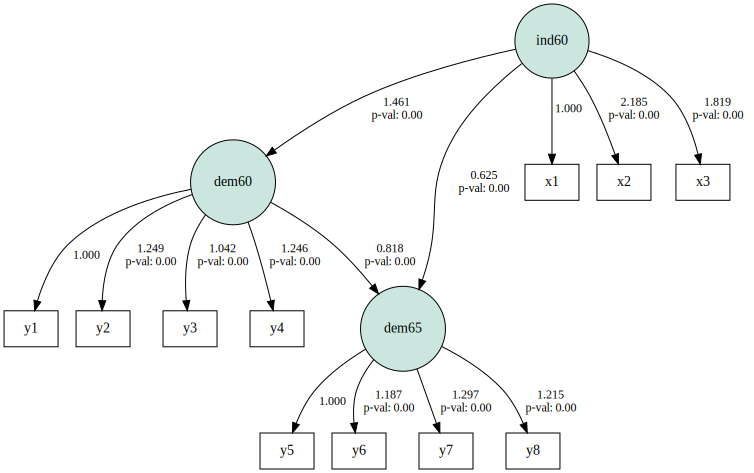

In [33]:
from semopy import semplot
g = semplot(m, filename='t.pdf')
g

Notice that you can edit *g* manually to fit your needs if you know the dot-language:

In [34]:
print(g)

digraph G {
	overlap=scale splines=true
	edge [fontsize=12]
	node [fillcolor="#cae6df" shape=circle style=filled]
	ind60 [label=ind60]
	dem60 [label=dem60]
	dem65 [label=dem65]
	node [shape=box style=""]
	x1 [label=x1]
	x2 [label=x2]
	x3 [label=x3]
	y1 [label=y1]
	y2 [label=y2]
	y3 [label=y3]
	y4 [label=y4]
	y5 [label=y5]
	y6 [label=y6]
	y7 [label=y7]
	y8 [label=y8]
	ind60 -> dem60 [label="1.461\np-val: 0.00"]
	ind60 -> dem65 [label="0.625\np-val: 0.00"]
	dem60 -> dem65 [label="0.818\np-val: 0.00"]
	ind60 -> x1 [label=1.000]
	ind60 -> x2 [label="2.185\np-val: 0.00"]
	ind60 -> x3 [label="1.819\np-val: 0.00"]
	dem60 -> y1 [label=1.000]
	dem60 -> y2 [label="1.249\np-val: 0.00"]
	dem60 -> y3 [label="1.042\np-val: 0.00"]
	dem60 -> y4 [label="1.246\np-val: 0.00"]
	dem65 -> y5 [label=1.000]
	dem65 -> y6 [label="1.187\np-val: 0.00"]
	dem65 -> y7 [label="1.297\np-val: 0.00"]
	dem65 -> y8 [label="1.215\np-val: 0.00"]
}


## Fit indices
**semopy** has some of the popular fit indices that researcher can examine to better understand his SEM model:

In [35]:
from semopy import calc_stats
calc_stats(m)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,35,55,42.937843,0.167616,733.810537,0.988306,0.941486,0.90805,0.941486,0.981624,0.055361,60.854991,132.697122,0.572505


## Robust standard errors
It is a common practice to use apply Huber-White correction to standard errors estimation. Whether it is a reasonable practice, [is debatable](https://www.tandfonline.com/doi/abs/10.1080/10705510701758091?scroll=top&needAccess=true&journalCode=hsem20), yet **semopy** provides such a functionality for a user's discretion via `se_robust` to the `inspect` method:

In [36]:
desc = political_democracy.get_model()
data = political_democracy.get_data()
m = Model(desc)
m.fit(data)
robust = m.inspect(se_robust=True)
robust

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,dem60,~,ind60,1.482379,0.337907,4.386943,0.000011
1,dem65,~,ind60,0.571912,0.206258,2.7728,0.005558
2,dem65,~,dem60,0.837574,0.086515,9.681209,0.0
3,x1,~,ind60,1.000000,-,-,-
4,x2,~,ind60,2.180494,0.143633,15.181011,0.0
5,x3,~,ind60,1.818546,0.139171,13.066974,0.0
6,y1,~,dem60,1.000000,-,-,-
7,y2,~,dem60,1.256819,0.140327,8.956363,0.0
8,y3,~,dem60,1.058174,0.13435,7.876242,0.0
9,y4,~,dem60,1.265186,0.12698,9.963697,0.0


## Random effects
Remember `ModelEffects`? Actually, it is true purpose is not modeling grouped data, but modeling the so-called random effects. It is really helpful in case where we know covariance matrix of residuals. It is mostly used in GWAS where such a covariance matrix is usually a matrix of genetic kinship between individuals.

Next, we are going to construct artifical model with such a covariance matrix *K* known, and then we are going to fit to the generated data:

In [37]:
import pandas as pd
np.random.seed(1)
n = 100 # Number of data samples
p = 3 # Number of indicators per latent factor
# Generating random parameters
params = [np.random.uniform(0.2, 1.2, size=(p - 1, 1)),
          np.random.uniform(0.2, 1.2, size=(p -1, 1))]
params = list(map(lambda x: np.append([1], x), params))
y = np.random.normal(size=(n, 2 * p))
# Generating factor scores
eta1 = np.random.normal(scale=1, size=(n, 1))
eta2 = np.random.normal(scale=1, size=(n, 1)) + 3 * eta1
# Loading factors onto indicators
y[:, :p] += np.kron(params[0], eta1)
y[:, p:] += np.kron(params[1], eta2)

# Intercepts!
means = np.random.normal(scale=3, size=2 * p)
y += means
params.append(means)

# Finally, random effects are here. They mess the data and there is nothing we could do...
u = np.random.normal(scale=3, size=y.shape)
y += u
# Unless we magically know the covariance matrix of those random effects!
k = u @ u.T
res = list()
d = {'eta1': list(), 'eta2': list()}
y_names = list()
for i in range(1, p + 1):
    res.append((f'y{i}', '~', 'eta1', params[0][i - 1]))
    res.append((f'y{i}', '~', '1', params[2][i - 1]))
    y_names.append(res[-1][0])
    d['eta1'].append(y_names[-1])
for j in range(1, p + 1):
    res.append((f'y{j + i}', '~', 'eta2', params[1][j - 1]))
    res.append((f'y{j + i}', '~', '1', params[2][i + j - 1]))
    y_names.append(res[-1][0])
    d['eta2'].append(y_names[-1])
desc = '\n'.join(f"{eta} =~ {' + '.join(ys)}" for eta, ys in d.items())
desc += '\neta2 ~ eta1'
params = pd.DataFrame.from_records(res, columns=['lval', 'op', 'rval', 'est'])
data = pd.DataFrame(np.append(np.append(y, eta1, axis=1), eta2, axis=1),
                    columns=y_names + ['eta1', 'eta2'])
data = data.drop(['eta1', 'eta2'], axis=1)
data['group'] = data.index

print(desc)
data.head()

eta1 =~ y1 + y2 + y3
eta2 =~ y4 + y5 + y6
eta2 ~ eta1


,y1,y2,y3,y4,y5,y6,group
0,-5.245105,2.541163,-1.995541,-9.116109,-0.708878,1.638819,0
1,2.579171,-0.296283,4.165746,-3.551921,-3.588691,5.024555,1
2,-3.652643,0.083678,-2.161153,-8.495831,-6.401319,3.464854,2
3,-4.290240,1.736493,0.095633,-3.534592,-1.230620,5.820926,3
4,-4.274387,-0.845491,-0.673557,2.267882,-4.332353,5.565805,4


The *group* column is not important in this particular case and is just needed to feed it to `ModelEffects`. It is possible that observations have a common "group" (like schools in the previous example with Holzinger-Swineford 1939). 
Now, before we actually try out the `ModelEffects`, let's see how well `ModelMeans` handles the situation:

In [38]:
m = ModelMeans(desc)
m.fit(data)
ins = m.inspect()
errs = list()
for _, row in params.iterrows():
    t = (ins['op'] == row['op']) & (ins['lval'] == row['lval']) &\
        (ins['rval'] == row['rval'])
    t = ins[t]
    est = t['Estimate'].values[0]
    errs.append(abs((est - row['est']) / row['est']))
err = np.mean(errs)
print("Mean relative error: {:.3f}%".format(err * 100))

Mean relative error: 48.069%


Not a great result. Let's now see if we can improve upon it by employing the `ModelEffects`:

In [39]:
m = ModelEffects(desc)
m.fit(data, group='group', k=k)
ins = m.inspect()
errs = list()
for _, row in params.iterrows():
    t = (ins['op'] == row['op']) & (ins['lval'] == row['lval']) &\
        (ins['rval'] == row['rval'])
    t = ins[t]
    est = t['Estimate'].values[0]
    errs.append(abs((est - row['est']) / row['est']))
err = np.mean(errs)
print("Mean relative error: {:.3f}%".format(err * 100))

Mean relative error: 14.426%


That's definitely better.

## Objective functions
**semopy** models have a variety of objective functions at user's disposal. You can select them by feeding the `obj` argument to the `fit` method. Here is the list of available objectives for each of the models (the first ones are the default ones):

- `Model`
1. `'MLW'` - Wishart Maximum Likelihood;
2. `'ULS'` - Unweighted Least Squares;
3. `'GLS'`- Generalized Least Squares;
4. `'FIML'` - Full Information Maximum Likelihood.
Take a note that `Model` handles missing data for all of the functions above, as 1-3 fit model to a covariance matrix that is calculated taking missing data into an account.
- `ModelMeans` 
1. `'FIML'` - Full Information Maximum Likelihood;
2. `'REML'` - Restricted Maximum Likelihood.
- `ModelEffects`
1. `'ML'` - Maximum Likelihood;
2. `'REML'` - Restricted Maximum Likelihood.

For example:

In [40]:
m = Model(desc)
print(m.fit(data, obj='ULS'))
m.inspect()

Name of objective: ULS
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 6.014
Number of iterations: 30
Params: 0.220 0.796 0.358 0.950 1.395 16.070 8.947 7.432 6.839 0.000 8.632 9.051 2.523


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,eta2,~,eta1,1.394963e+00,0.744385,1.873981,0.060933
1,y1,~,eta1,1.000000e+00,-,-,-
2,y2,~,eta1,2.200319e-01,0.252588,0.871109,0.383695
3,y3,~,eta1,7.963104e-01,0.315811,2.521478,0.011686
4,y4,~,eta2,1.000000e+00,-,-,-
5,y5,~,eta2,3.583617e-01,0.198462,1.805693,0.070966
6,y6,~,eta2,9.501895e-01,0.34289,2.771122,0.005586
7,eta2,~~,eta2,7.189092e-17,2.520223,0.0,1.0
8,eta1,~~,eta1,2.523207e+00,1.559162,1.618309,0.105596
9,y4,~~,y4,1.607024e+01,2.903285,5.535192,0.0
